In [163]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
import warnings
warnings.filterwarnings('ignore')

In [204]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np

from sklearn.ensemble        import RandomForestClassifier, \
                                    AdaBoostClassifier, \
                                    GradientBoostingClassifier
from sklearn.model_selection import train_test_split,LeaveOneGroupOut, KFold, ShuffleSplit
from sklearn.metrics         import accuracy_score

from data   import Dataset
from metric import plot_learning_curve

In [166]:
def exclude_columns(df, columns): return df.drop(columns, axis=1)

In [7]:
dataset = pd.read_csv('dataset.csv')

Quitamos columnas que no vamos usar como:

In [11]:
example_columns  = set(dataset.columns) - set([
    'Unnamed: 0',
    'file',
    'modality',
    'statement',
    'repetition',
    'start',
    'end'
])
target_column = 'emotion'

# Esta dos columnas se usan mas adelantes para hacer fold de los actores 
# y luego para agregar ruido a los audios.
special_columns = ['actor', 'file_path']

Luego codificamos **vocal_channel** como dummy y separamos en features de target:

In [12]:
dataset['vocal_channel'].value_counts()

1    1440
2    1012
Name: vocal_channel, dtype: int64

In [13]:
def features_target(df):
    df = df[example_columns]
    df['vocal_channel'] = pd.get_dummies(df['vocal_channel'])
    return exclude_columns(df, [target_column]),  df[[target_column]]

In [14]:
features, target = features_target(dataset)

In [15]:
features['vocal_channel'].value_counts()

1    1440
0    1012
Name: vocal_channel, dtype: int64

Analizamos si hay valores faltantes:

In [16]:
missing_values_summary(features)

Series([], dtype: float64)

Vemos que esta codificado el campo: 0 para speech y 1 para song.

Partimos en dev y test:

In [17]:
random_state = 1
test_size    = 0.3

In [18]:
X_dev, X_test, y_dev, y_test = train_test_split(
    features, 
    target, 
    test_size    = test_size, 
    stratify     = target, 
    random_state = random_state,
    shuffle      = True
)

#### 2. Ahora vamos a probar modelos con dos estrategias distintas de cross validation.

**Estrategia 1**: 12-fold cross validation armando los folds de forma aleatoria.

In [40]:
cv_strategy_1 = KFold(n_splits=12, shuffle=True)

In [41]:
X_Dev_input  = exclude_columns(X_dev, special_columns)
X_Test_input = exclude_columns(X_test, special_columns)

In [147]:
from tqdm import tqdm

def cross_validation(create_model_fn, X_train, y_train, cv, groups=None):
    metrics = []
    time    = 1
    times   = cv.get_n_splits(X_train, y_train, groups)
    pbar    = tqdm(total=times, position=0, leave=True)
    
    for train_index, val_index in cv.split(X_train, groups=groups):
        x_train  = X_train.to_numpy()[train_index, :]
        y_train_ = y_train.to_numpy()[train_index, :]
        x_val    = X_train.to_numpy()[val_index, :]
        y_val    = y_train.to_numpy()[val_index, :]

        model = create_model_fn()
        model.fit(x_train, y_train_)

        acc = accuracy_score(y_val, model.predict(x_val))
        metrics.append(acc)
        
        pbar.set_description('Model: {}, Accuracy {:.3f} %'.format(time, acc * 100))
        pbar.update()
        time += 1

    print('\nMean Accuracy: {:.6f} %\n'.format(np.mean(metrics) * 100))
    return metrics

Random Forest:

In [148]:
cv_strategy_1.n_splits

12

In [149]:
%%time
cross_validation(lambda: RandomForestClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Model: 12, Accuracy 62.937 %: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


Mean Accuracy: 65.909091 %

CPU times: user 6.38 s, sys: 3.33 ms, total: 6.38 s
Wall time: 6.38 s


[0.7062937062937062,
 0.6153846153846154,
 0.6363636363636364,
 0.6153846153846154,
 0.6363636363636364,
 0.7272727272727273,
 0.6223776223776224,
 0.7132867132867133,
 0.6713286713286714,
 0.6783216783216783,
 0.6573426573426573,
 0.6293706293706294]

Ada Boost:

In [122]:
%%time
cross_validation(lambda: AdaBoostClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Model: 12, Accuracy 37.063 %: 100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Mean Accuracy: 38.694639 %

CPU times: user 6.07 s, sys: 1 µs, total: 6.07 s
Wall time: 6.07 s


[0.4195804195804196,
 0.38461538461538464,
 0.42657342657342656,
 0.34965034965034963,
 0.36363636363636365,
 0.38461538461538464,
 0.3776223776223776,
 0.4405594405594406,
 0.38461538461538464,
 0.3076923076923077,
 0.43356643356643354,
 0.3706293706293706]

Gradient Boosting:

In [123]:
%%time
cross_validation(lambda: GradientBoostingClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Model: 12, Accuracy 62.937 %: 100%|██████████| 12/12 [03:38<00:00, 18.17s/it]


Mean Accuracy: 65.034965 %

CPU times: user 3min 38s, sys: 9.89 ms, total: 3min 38s
Wall time: 3min 38s


[0.6293706293706294,
 0.6293706293706294,
 0.6503496503496503,
 0.6713286713286714,
 0.7132867132867133,
 0.6293706293706294,
 0.5944055944055944,
 0.6783216783216783,
 0.6083916083916084,
 0.6503496503496503,
 0.7202797202797203,
 0.6293706293706294]

**Estrategia 2**: Leave-2-speakers out. Es decir, 12 folds conteniendo cada uno 2 actores distintos.

La siguiente funcion toma todos los posibles valores de la columna especificada en **input_column** los agrupa en grupos de tamaño **group_size** y luego agrega uni nueva columna (**target_column**) donde se especifica cada fila a que grupo pertenese:

In [139]:
def sample_groups(X, column, group_size):
    numbers = X[column].unique()
    sample  = np.random.choice(numbers, size=len(numbers), replace=False)
    
    return sample.reshape((int(len(numbers) / group_size), group_size))

def set_groups(X, column, group_size):
    tmp = X.copy()

    index = int(max(X[column].unique())) + 1
    for group in sample_groups(X, column, group_size):
        tmp[column] = tmp[column].apply(lambda x: index if x in group else x)
        index += 1

    return tmp

In [140]:
sample_groups(X_dev, 'actor', 2)

array([[16, 18],
       [24,  4],
       [ 9,  5],
       [ 2,  3],
       [17, 10],
       [ 1, 11],
       [15,  6],
       [13,  8],
       [14,  7],
       [21, 19],
       [20, 12],
       [23, 22]])

In [141]:
X_dev_tmp = set_groups(X_dev, column='actor', group_size=2)

actors_fold_input  = exclude_columns(X_dev_tmp, special_columns)
actors_fold_groups = X_dev_tmp['actor']

Nos quedan 12 grupos de 2 actores cada uno:

In [142]:
len(actors_fold_groups.unique())

12

In [143]:
actors_fold_groups.value_counts()

36    156
33    153
31    150
27    147
32    146
26    145
25    143
29    143
34    142
35    140
30    138
28    113
Name: actor, dtype: int64

In [144]:
cv_strategy_2 = LeaveOneGroupOut()

Random Forest:

In [150]:
%%time
cross_validation(lambda: RandomForestClassifier(), actors_fold_input, y_dev, cv_strategy_2, groups=actors_fold_groups)

Model: 12, Accuracy 58.333 %: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


Mean Accuracy: 53.222929 %

CPU times: user 6.32 s, sys: 6.66 ms, total: 6.33 s
Wall time: 6.33 s


[0.5594405594405595,
 0.5517241379310345,
 0.5850340136054422,
 0.5663716814159292,
 0.4965034965034965,
 0.5,
 0.46,
 0.410958904109589,
 0.5098039215686274,
 0.5492957746478874,
 0.6142857142857143,
 0.5833333333333334]

Ada Boost:

In [151]:
%%time
cross_validation(lambda: AdaBoostClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Model: 12, Accuracy 39.103 %: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Mean Accuracy: 33.880915 %

CPU times: user 6.17 s, sys: 0 ns, total: 6.17 s
Wall time: 6.17 s


[0.32167832167832167,
 0.3931034482758621,
 0.3129251700680272,
 0.39823008849557523,
 0.34965034965034963,
 0.34057971014492755,
 0.31333333333333335,
 0.17123287671232876,
 0.38562091503267976,
 0.31690140845070425,
 0.37142857142857144,
 0.391025641025641]

Gradient Boosting:

In [152]:
%%time
cross_validation(lambda: GradientBoostingClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Model: 12, Accuracy 64.103 %: 100%|██████████| 12/12 [03:41<00:00, 18.32s/it]


Mean Accuracy: 53.765111 %

CPU times: user 3min 41s, sys: 3.33 ms, total: 3min 41s
Wall time: 3min 41s


[0.5174825174825175,
 0.5655172413793104,
 0.5918367346938775,
 0.584070796460177,
 0.5314685314685315,
 0.5289855072463768,
 0.48,
 0.363013698630137,
 0.5555555555555556,
 0.5,
 0.5928571428571429,
 0.6410256410256411]

<module 'matplotlib.pyplot' from '/home/adrian/anaconda3/envs/aa-tp2/lib/python3.8/site-packages/matplotlib/pyplot.py'>

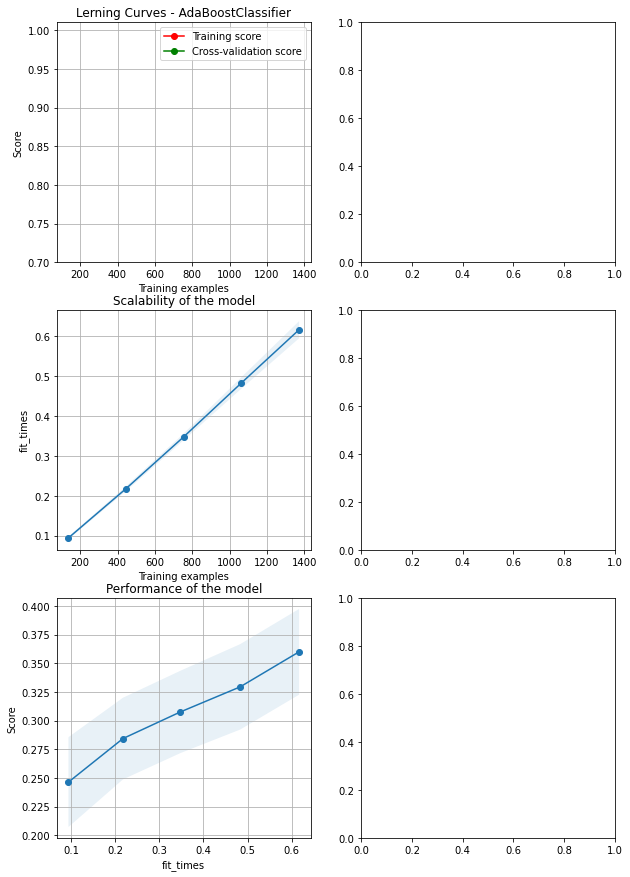

In [205]:

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

plot_learning_curve(
    AdaBoostClassifier(), 
    actors_fold_input, 
    y_dev,
    cv     = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0),
    n_jobs = 24,
    axes   = axes[:, 0], 
    ylim   = (0.7, 1.01)
)